<a href="https://colab.research.google.com/github/alejandracardonavelasco/ML-/blob/main/Lab9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Lab 9**

In [ ]:
import torch
import torchvision

transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(28 * 28, 1024)
        self.linear2 = torch.nn.Linear(1024, 2048)
        self.linear3 = torch.nn.Linear(2048, 256)
        self.linear4 = torch.nn.Linear(256, 10)
        self.dropout = torch.nn.Dropout(0.05)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.linear4(x)
        x = self.dropout(x)
        return x


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = MLP().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(8):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        #batch_inputs.squeeze(1)     #alternatively if not for a Flatten layer, squeeze() could be used to remove the second order of the tensor, the Channel, which is one-dimensional (this index can be equal to 0 only)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear
                                            #and MLP doesn't apply
                                            #the nonlinear activation after the last layer
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 493kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.55MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.51MB/s]


Working on cuda
epoch: 0 batch: 0 current batch loss: 2.304292917251587
epoch: 0 batch: 1 current batch loss: 2.0664010047912598
epoch: 0 batch: 2 current batch loss: 1.6494101285934448
epoch: 0 batch: 3 current batch loss: 1.15922212600708
epoch: 0 batch: 4 current batch loss: 0.9968281984329224
epoch: 0 batch: 5 current batch loss: 0.9075694680213928
epoch: 0 batch: 6 current batch loss: 1.0541598796844482
epoch: 0 batch: 7 current batch loss: 0.9432876110076904
epoch: 0 batch: 8 current batch loss: 0.7213155627250671
epoch: 0 batch: 9 current batch loss: 0.7455103993415833
epoch: 0 batch: 10 current batch loss: 0.8172540664672852
epoch: 0 batch: 11 current batch loss: 0.5924995541572571
epoch: 0 batch: 12 current batch loss: 0.5533026456832886
epoch: 0 batch: 13 current batch loss: 0.5613369345664978
epoch: 0 batch: 14 current batch loss: 0.5686874985694885
epoch: 0 batch: 15 current batch loss: 0.5112699866294861
epoch: 0 batch: 16 current batch loss: 0.48521751165390015
epoch: 0 b

## **Task 1:** Generate a batch of 10 images, where each image is classified as one of the digits 0, 1, 2, ..., 9, starting from an initial batch of ten random Gaussian noise images.

Step 0, Loss: 4.9951
Step 50, Loss: 1.6590
Step 100, Loss: 0.5293
Step 150, Loss: 0.1896
Step 200, Loss: 0.1006
Step 250, Loss: 0.0669
Step 300, Loss: 0.0488
Step 350, Loss: 0.0377
Step 400, Loss: 0.0302
Step 450, Loss: 0.0249


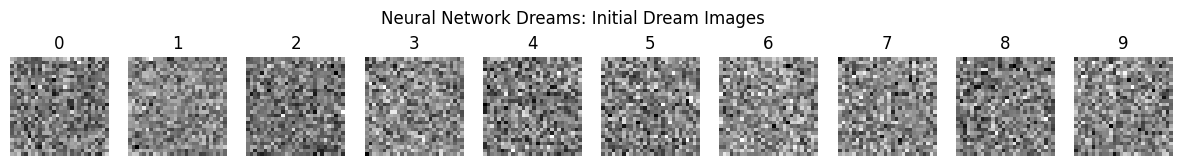

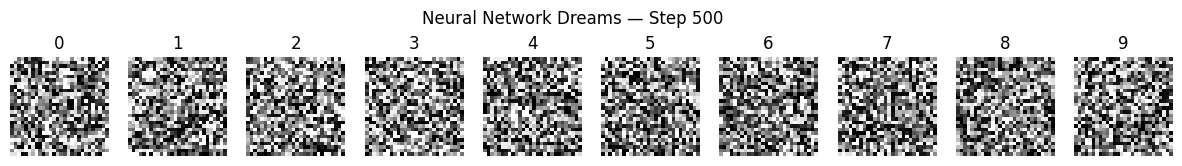

In [42]:
# We freeze the model
net.eval()
for param in net.parameters():
    param.requires_grad = False

# Dreaming inputs
dream_images = torch.nn.Parameter(torch.randn(10, 1, 28, 28, device=device))
target_labels = torch.arange(10, device=device)  # tensor([0, 1, 2, ..., 9])
optimizer = torch.optim.Adam([dream_images], lr=0.001)

import matplotlib.pyplot as plt

dream_images_cpu = dream_images.detach().cpu()
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(dream_images_cpu[i][0], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(str(i))
plt.suptitle("Neural Network Dreams: Initial Dream Images")

for step in range(500):
    # Save the frames
    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    dream_images_cpu = dream_images.detach().cpu()
    for i in range(10):
          axes[i].imshow(dream_images_cpu[i][0], cmap='gray')
          axes[i].axis('off')
          axes[i].set_title(str(i))
    plt.suptitle(f"Neural Network Dreams — Step {step}")
    plt.savefig(f"frame_{step:04d}.png")
    plt.close(fig)

    # Optimization process
    optimizer.zero_grad()
    outputs = net(dream_images)

    loss = torch.nn.functional.cross_entropy(outputs, target_labels)  # Encourage each image to be classified correctly
    loss.backward()
    optimizer.step()

    # Clamp pixel range to prevent extreme values
    with torch.no_grad():
      dream_images.clamp_(-1.0, 1.0)

    if step % 50 == 0:
        print(f"Step {step}, Loss: {loss.item():.4f}")

# Final image
dream_images_cpu = dream_images.detach().cpu()
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(dream_images_cpu[i][0], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(str(i))
plt.suptitle(f"Neural Network Dreams — Step 500")
plt.savefig(f"frame_500.png")  # Save the frame
plt.show()

We can verify that the images are being classified correctly:


In [31]:
with torch.no_grad():
    preds = torch.argmax(net(dream_images), dim=1)
    print("Predictions:", preds.tolist())


Predictions: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [32]:
# Now we create an animation with the frames we saved
import imageio
import glob

frames = []
for filename in sorted(glob.glob("frame_*.png")):
    frames.append(imageio.imread(filename))

# Save to MP4
imageio.mimsave("dreams.mp4", frames, fps=10)

from google.colab import files
files.download("dreams.mp4")


<ipython-input-32-21683b9d7ddb>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(filename))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Question: Do the generated images resemble real MNIST digits? Why or why not?
No, it doesn't look like real MNIST digits.

The network's goal is not to generate human-readable digits, but to maximize its own internal confidence. The optimization process is pushing the input to activate certain neurons,it doesn't care if the image looks like a digit to you, only that the network outputs the correct class label.

Also, there's no regularization or constraint on visual realism.
We are not telling the model to produce natural shapes, just to maximize classification confidence. That can result in strange patterns or noisy textures that exploit how the network was trained.

## **Task 2:** Discuss, how you would approach a second task of generating an image that bares similarity to two or more digits simultaneously. Implement your idea to see the results.

Instead of maximizing the confidence for one class, we now want to simultaneously increase the confidence for two or more classes. This leads us to a multi-target optimization, where we combine multiple class objectives in a single loss.

In order to do this, we will use the code we did for task 1 but modifying the loss function. We will use binary cross-entropy with soft labels to simultaneously increase the model's confidence in multiple target classes, allowing us to generate a single image that the neural network classifies as resembling both digits at once.

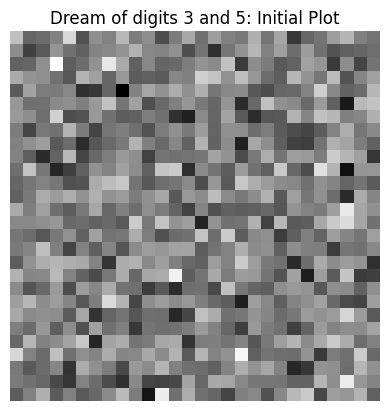

Step 0, Loss: 0.3601
Step 50, Loss: 0.1613
Step 100, Loss: 0.1472
Step 150, Loss: 0.1439
Step 200, Loss: 0.1425
Step 250, Loss: 0.1416
Step 300, Loss: 0.1411
Step 350, Loss: 0.1407
Step 400, Loss: 0.1404
Step 450, Loss: 0.1401


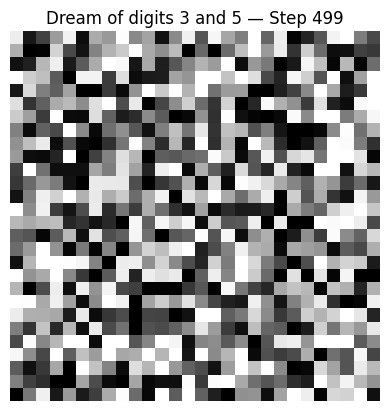

In [39]:
target_classes = [3, 5]
dream_images = torch.nn.Parameter(torch.randn(10, 1, 28, 28, device=device))
multi_digit_img = torch.nn.Parameter(torch.randn(1, 1, 28, 28, device=device))
optimizer = torch.optim.Adam([multi_digit_img], lr=0.001)

# Visualize final dreams
fig, ax = plt.subplots()
plt.imshow(multi_digit_img.detach().cpu()[0][0], cmap='gray')
plt.title(f"Dream of digits {target_classes[0]} and {target_classes[1]}: Initial Plot")
plt.axis('off')
plt.show()

for step in range(500):  # Tune number of steps as needed
    # Save images
    fig, ax = plt.subplots()
    plt.imshow(multi_digit_img.detach().cpu()[0][0], cmap='gray')
    plt.title(f"Dream of digits {target_classes[0]} and {target_classes[1]} — Step {step}")
    plt.axis('off')
    plt.savefig(f"frame2_{step:04d}.png")  # Save the frame
    plt.close(fig)

    optimizer.zero_grad()
    output = net(multi_digit_img)              # Shape: [1, 10]
    probs = torch.nn.functional.softmax(output, dim=1)           # Turn logits into probabilities

    # Define soft target: 0.5 for class 3 and 0.5 for class 5
    soft_target = torch.zeros_like(probs)
    soft_target[0, 3] = 0.5
    soft_target[0, 5] = 0.5

    # Binary cross-entropy between predicted probs and soft target
    loss = torch.nn.functional.binary_cross_entropy(probs, soft_target)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        multi_digit_img.clamp_(-1.0, 1.0)

    if step % 50 == 0:
        print(f"Step {step}, Loss: {loss.item():.4f}")

import matplotlib.pyplot as plt

# Visualize final dreams
fig, ax = plt.subplots()
plt.imshow(multi_digit_img.detach().cpu()[0][0], cmap='gray')
plt.title(f"Dream of digits {target_classes[0]} and {target_classes[1]} — Step {step}")
plt.axis('off')
plt.savefig(f"frame2_{step:04d}.png")  # Save the frame
plt.show()
plt.close(fig)


In [40]:
# We create the animation
frames2 = []
for filename in sorted(glob.glob("frame2_*.png")):
    frames2.append(imageio.imread(filename))

# Save to MP4
imageio.mimsave("dreams2.mp4", frames2, fps=10)

files.download("dreams2.mp4")

<ipython-input-40-b0cb95fe01a6>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames2.append(imageio.imread(filename))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Task 3:** Repeat the previous tasks with an additional L2 penalty on noise within the images. Experiment with adding `lambda_l2 * dreamed_input_batch.pow(2).mean()` loss term, with `lambda_l2` being the penalty cooefficient within an exponential progression, say from 0.001 to 10.0


 L2 Penalty λ = 0.001
Step 0 — Loss: 4.9050, CE: 4.9040, L2: 0.0010
Step 100 — Loss: 0.7218, CE: 0.7213, L2: 0.0005
Step 200 — Loss: 0.1007, CE: 0.1003, L2: 0.0005
Step 300 — Loss: 0.0468, CE: 0.0463, L2: 0.0005
Step 400 — Loss: 0.0290, CE: 0.0285, L2: 0.0005


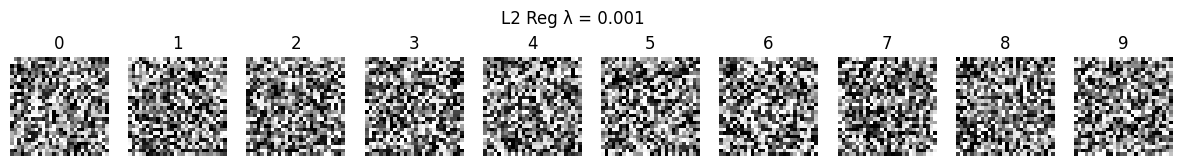

Predictions: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

 L2 Penalty λ = 0.01
Step 0 — Loss: 5.0887, CE: 5.0785, L2: 0.0102
Step 100 — Loss: 0.8414, CE: 0.8364, L2: 0.0050
Step 200 — Loss: 0.2291, CE: 0.2242, L2: 0.0049
Step 300 — Loss: 0.0785, CE: 0.0737, L2: 0.0049
Step 400 — Loss: 0.0397, CE: 0.0348, L2: 0.0048


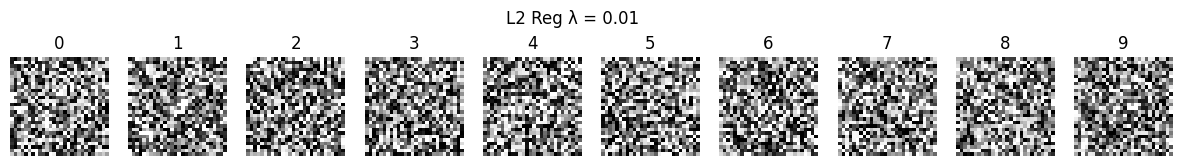

Predictions: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

 L2 Penalty λ = 0.1
Step 0 — Loss: 4.7009, CE: 4.6007, L2: 0.1002
Step 100 — Loss: 0.6836, CE: 0.6349, L2: 0.0487
Step 200 — Loss: 0.1515, CE: 0.1036, L2: 0.0479
Step 300 — Loss: 0.0959, CE: 0.0484, L2: 0.0475
Step 400 — Loss: 0.0768, CE: 0.0296, L2: 0.0472


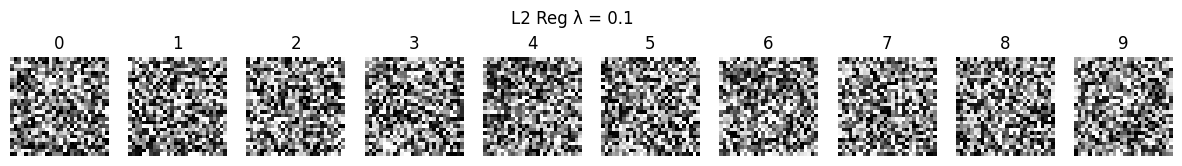

Predictions: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

 L2 Penalty λ = 1.0
Step 0 — Loss: 5.7371, CE: 4.7290, L2: 1.0080
Step 100 — Loss: 1.4742, CE: 0.9937, L2: 0.4805
Step 200 — Loss: 0.6772, CE: 0.2228, L2: 0.4545
Step 300 — Loss: 0.4977, CE: 0.0662, L2: 0.4315
Step 400 — Loss: 0.4433, CE: 0.0336, L2: 0.4096


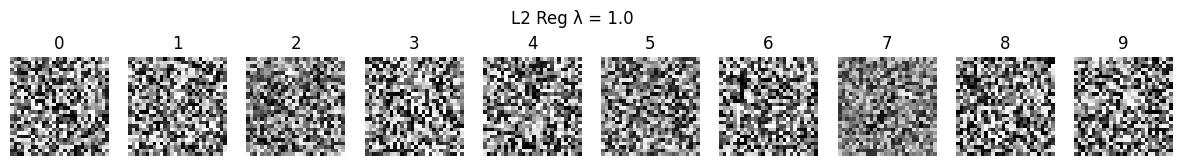

Predictions: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

 L2 Penalty λ = 10.0
Step 0 — Loss: 14.7066, CE: 4.4348, L2: 10.2719
Step 100 — Loss: 5.1658, CE: 0.5649, L2: 4.6009
Step 200 — Loss: 4.1176, CE: 0.1147, L2: 4.0029
Step 300 — Loss: 3.4886, CE: 0.0731, L2: 3.4155
Step 400 — Loss: 2.9464, CE: 0.0601, L2: 2.8863


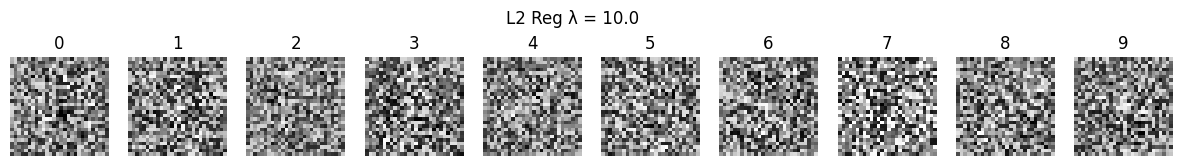

Predictions: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [45]:

# Define different regularization strengths to test
lambdas = [0.001, 0.01, 0.1, 1.0, 10.0]

for lambda_l2 in lambdas:
    print(f"\n L2 Penalty λ = {lambda_l2}")

    # Create trainable noise batch: 10 images
    dreamed_imgs = torch.nn.Parameter(torch.randn(10, 1, 28, 28, device=device))
    target_labels = torch.arange(10, device=device)
    optimizer = torch.optim.Adam([dreamed_imgs], lr=0.001)

    for step in range(500):

        # Save frame for current step and lambda
        images_cpu = dreamed_imgs.detach().cpu()
        fig, axs = plt.subplots(1, 10, figsize=(15, 2))
        for i in range(10):
            axs[i].imshow(images_cpu[i][0], cmap='gray', vmin=-1.0, vmax=1.0)
            axs[i].axis('off')
            axs[i].set_title(str(i))
        plt.suptitle(f"Step {step} — L2 λ={lambda_l2}")
        plt.savefig(f"lambda_{lambda_l2:.3f}_step_{step:04d}.png")
        plt.close(fig)

        optimizer.zero_grad()
        output = net(dreamed_imgs)  # Shape: [10, 10]
        ce_loss = torch.nn.functional.cross_entropy(output, target_labels)  # classification loss
        l2_penalty = lambda_l2 * dreamed_imgs.pow(2).mean()  # L2 penalty on pixel intensity

        loss = ce_loss + l2_penalty
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            dreamed_imgs.clamp_(-1.0, 1.0)

        if step % 100 == 0 or step == max_steps - 1:
            print(f"Step {step} — Loss: {loss.item():.4f}, CE: {ce_loss.item():.4f}, L2: {l2_penalty.item():.4f}")

    # Visualization
    images_cpu = dreamed_imgs.detach().cpu()
    fig, axs = plt.subplots(1, 10, figsize=(15, 2))
    for i in range(10):
        axs[i].imshow(images_cpu[i][0], cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(str(i))
    plt.suptitle(f"L2 Reg λ = {lambda_l2}")
    plt.show()

    # Prediction check
    with torch.no_grad():
        predictions = torch.argmax(net(dreamed_imgs), dim=1)
        print("Predictions:", predictions.cpu().tolist())


In [47]:
lambdas = [0.001, 0.01, 0.1, 1.0, 10.0]

for lambda_l2 in lambdas:
    pattern = f"lambda_{lambda_l2:.3f}_step_*.png"
    frame_paths = sorted(glob.glob(pattern))
    frames = [imageio.v2.imread(fp) for fp in frame_paths]
    output_path = f"dream_lambda_{lambda_l2:.3f}.mp4"
    imageio.mimsave(output_path, frames, fps=10)  # Adjust fps if needed
    files.download(output_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Question: Are the new digits recognized correctly? How does the penalty impact the digit quality? Explain
No, the pictures still don't look like real digits. As in task 1, this is because we are only optimizing for the model's internal feature activation, not for human-recognizable structure. Without explicit constraints that enforce digit-like appearance, the optimization produces high-confidence but abstract or noisy results.

The L2 penalty acts as a regularizer, preventing the optimizer from using extreme pixel values just to fool the network. It adds a cost for having large-valued pixels. So as $\lambda$ increases, the optimizer is "afraid" to activate pixels strongly, it prefers to keep them near zero. It encourages solutions that are more "distributed" and smoother.
- **Low $\lambda$** (0.001-0.01): We get sharp, noisy, unnatural digits.
- **Moderate $\lambda$** (0.01-0.1): We get smoother images, more digit-like structure
- **High $\lambda$** (1-10): We get blurry images